# Preperation

### Imports

In [1]:
import os
import re
import random
import joblib

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import torch

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ilian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Seed

In [3]:
def set_seed(seed=42):
    np.random.seed(seed)     
    random.seed(seed)             
    os.environ['PYTHONHASHSEED'] = str(seed)  
    
    # TensorFlow
    tf.random.set_seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  

set_seed(42)  


### Paths

In [4]:
import sys, os
sys.path.append(os.path.abspath('../../src'))

from helper_functions.path_resolver import DynamicPathResolver

In [5]:
dpr = DynamicPathResolver(marker="README.md")

train_preprocessed = dpr.path.data.preprocessed.data_meta.train_processed_balanced_csv
test_preprocessed  = dpr.path.data.preprocessed.data_meta.test_processed_en_de_csv

models_folder = dpr.path.models.meta._path
output_dir    = dpr.path.models.meta.results._path

Project Root: c:\Users\ilian\Documents\Projects\git_projects\university\phishing_detection


### Functions

In [6]:
def load_preprocessed_data(train_load_path, test_load_path):
    df_train = pd.read_csv(train_load_path)
    df_test = pd.read_csv(test_load_path)
    return df_train, df_test

In [7]:
def load_model(model_name):
    model_path = os.path.join(models_folder, f"{model_name.replace(' ', '_').lower()}.pkl")
    return joblib.load(model_path)

In [8]:
def conditional_scaling(X_train, X_val, scale=False):
    if scale:
        scaler = StandardScaler() # StandardScaler # MinMaxScaler
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        return X_train_scaled, X_val_scaled
    return X_train, X_val


In [ ]:
def evaluate_model(model_name, test_file, models_folder):
    # Load preprocessed
    df_test = pd.read_csv(test_file)
    y_test = df_test['label']
    X_test = df_test.drop(columns=['label'])

    # Load model
    model = load_model(model_name)

    # Load vectorizer
    vectorizer_path = os.path.join(models_folder, "tfidf_vectorizer.pkl")
    vectorizer = joblib.load(vectorizer_path)

    # Extract text & numerical
    X_test_text = X_test['body']
    X_test_numerical = X_test.drop(columns=['body'])

    # Vectorize
    X_test_tfidf = vectorizer.transform(X_test_text)

    # Scale numericals
    if model_name in ["log_regression"]:
        _, X_test_numerical_scaled = conditional_scaling(X_test_numerical, X_test_numerical, scale=True)
    else:
        _, X_test_numerical_scaled = conditional_scaling(X_test_numerical, X_test_numerical, scale=False)

    # Combine and pred
    X_test_combined = np.hstack([X_test_tfidf.toarray(), X_test_numerical_scaled])
    y_pred = model.predict(X_test_combined)

    # Classification report
    print(f"\nEvaluation for {model_name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    display(report_df)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Ham', 'Phishing'], yticklabels=['Ham', 'Phishing'])
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

### Load data

In [10]:
df_train, df_test = load_preprocessed_data(train_preprocessed, test_preprocessed)

### Train, Val Split

In [11]:
X = df_train.drop(columns=['label'])
y = df_train['label']

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Save body

In [13]:
X_train_text = X_train['body']
X_val_text = X_val['body']

### Scale features

In [14]:
X_train_numerical = X_train.drop(columns=['body'])
X_val_numerical = X_val.drop(columns=['body'])

In [15]:
X_train_unscaled, X_val_unscaled = conditional_scaling(X_train_numerical, X_val_numerical, scale=False)
X_train_scaled, X_val_scaled = conditional_scaling(X_train_numerical, X_val_numerical, scale=True)

### Combine stopwords

In [16]:
stop_words = set(stopwords.words('english')) | set(stopwords.words('german')) 
stop_words_list = list(stop_words) 

### Vectorizer

In [17]:
vectorizer = TfidfVectorizer(stop_words=stop_words_list, max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_val_tfidf = vectorizer.transform(X_val_text)

joblib.dump(vectorizer, os.path.join(models_folder, "tfidf_vectorizer.pkl"))

['c:\\Users\\ilian\\Documents\\Projects\\git_projects\\university\\phishing_detection\\models\\meta\\tfidf_vectorizer.pkl']

### Stack features (TF-IDF & Custom)

In [18]:
X_train_combined_unscaled = np.hstack([X_train_tfidf.toarray(), X_train_unscaled])
X_val_combined_unscaled = np.hstack([X_val_tfidf.toarray(), X_val_unscaled])

In [19]:
X_train_combined_scaled = np.hstack([X_train_tfidf.toarray(), X_train_scaled])
X_val_combined_scaled = np.hstack([X_val_tfidf.toarray(), X_val_scaled])

### Train

In [20]:
models = {
    "naive_bayes": MultinomialNB(),
    "log_regression": LogisticRegression(max_iter=500),
    "decision_tree": DecisionTreeClassifier(),
    "random_forest": RandomForestClassifier(),
}

##### Naive Bayes

In [21]:
param_grid_nb = {'alpha': [0.01, 0.1, 0.5, 1, 2, 5]}

nb = MultinomialNB()

grid_search_nb = GridSearchCV(nb, param_grid_nb, cv=5, n_jobs=-1)
grid_search_nb.fit(X_train_combined_unscaled, y_train)

best_nb = grid_search_nb.best_estimator_

joblib.dump(best_nb, os.path.join(models_folder, "naive_bayes.pkl"))
print("Best Naive Bayes params:", grid_search_nb.best_params_)

Best Naive Bayes params: {'alpha': 0.01}


##### Logistic Regression

In [ ]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'solver': ['liblinear', 'saga'], 
    'max_iter': [200, 500, 1000]
    }

lr = LogisticRegression()

grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, n_jobs=-1)
grid_search_lr.fit(X_train_combined_scaled, y_train)

best_lr = grid_search_lr.best_estimator_

joblib.dump(best_lr, os.path.join(models_folder, "log_regression.pkl"))
print("Best Logistic Regression params:", grid_search_lr.best_params_)

##### Decision Tree

In [ ]:
param_grid_dt = {
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4], 
    'criterion': ['gini', 'entropy']
    }

dt = DecisionTreeClassifier()

grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, n_jobs=-1)
grid_search_dt.fit(X_train_combined_unscaled, y_train)

best_dt = grid_search_dt.best_estimator_
joblib.dump(best_dt, os.path.join(models_folder, "decision_tree.pkl"))

print("Best Decision Tree params:", grid_search_dt.best_params_)

##### Random Forest

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200, 500], 
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4]
    }

rf = RandomForestClassifier()

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1)
grid_search_rf.fit(X_train_combined_unscaled, y_train)

best_rf = grid_search_rf.best_estimator_

joblib.dump(best_rf, os.path.join(models_folder, "random_forest.pkl"))
print("Best Random Forest params:", grid_search_rf.best_params_)

### Evaluation

In [22]:
models_to_evaluate = [
    ("naive_bayes", best_nb),
    ("log_regression", best_lr),
    ("decision_tree", best_dt),
    ("random_forest", best_rf)
]



Evaluation for naive_bayes
Accuracy: 0.6035


,precision,recall,f1-score,support
0,0.610459,0.5720,0.590604,2000.0000
1,0.597366,0.6350,0.615608,2000.0000
accuracy,0.603500,0.6035,0.603500,0.6035
macro avg,0.603912,0.6035,0.603106,4000.0000
weighted avg,0.603912,0.6035,0.603106,4000.0000


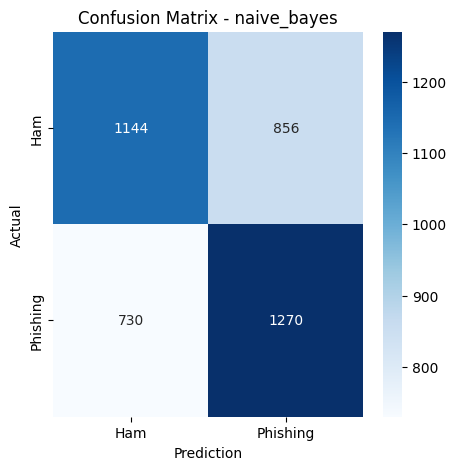


Evaluation for log_regression
Accuracy: 0.7490


,precision,recall,f1-score,support
0,0.746535,0.754,0.750249,2000.000
1,0.751515,0.744,0.747739,2000.000
accuracy,0.749000,0.749,0.749000,0.749
macro avg,0.749025,0.749,0.748994,4000.000
weighted avg,0.749025,0.749,0.748994,4000.000


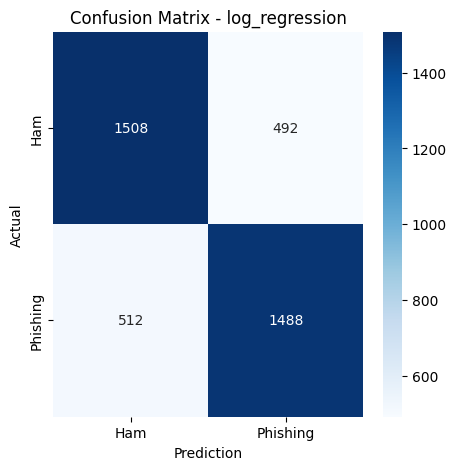


Evaluation for decision_tree
Accuracy: 0.6060


,precision,recall,f1-score,support
0,0.586531,0.7185,0.645843,2000.000
1,0.636774,0.4935,0.556056,2000.000
accuracy,0.606000,0.6060,0.606000,0.606
macro avg,0.611652,0.6060,0.600950,4000.000
weighted avg,0.611652,0.6060,0.600950,4000.000


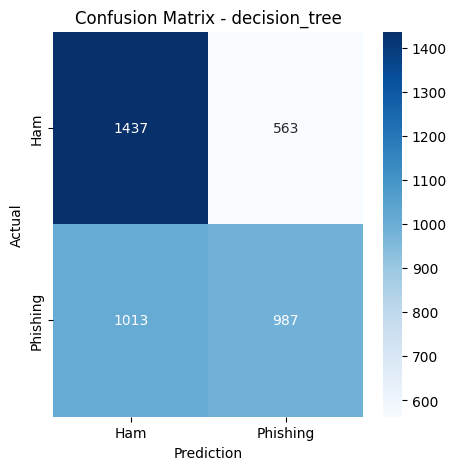


Evaluation for random_forest
Accuracy: 0.7278


,precision,recall,f1-score,support
0,0.692113,0.82050,0.750858,2000.00000
1,0.779619,0.63500,0.699917,2000.00000
accuracy,0.727750,0.72775,0.727750,0.72775
macro avg,0.735866,0.72775,0.725388,4000.00000
weighted avg,0.735866,0.72775,0.725388,4000.00000


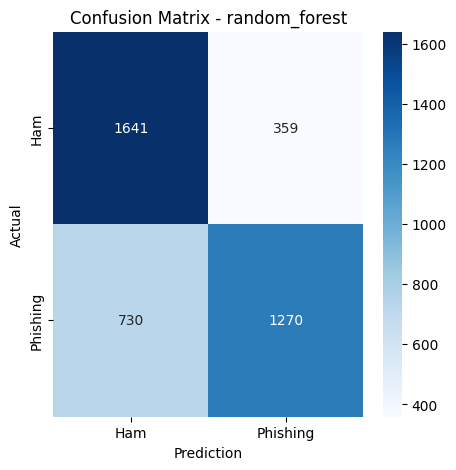

In [23]:
for name, model in models_to_evaluate:
    evaluate_model(name, test_preprocessed, models_folder)


### Ensemble

In [21]:
best_nb = joblib.load(os.path.join(models_folder, "naive_bayes.pkl"))
best_lr = joblib.load(os.path.join(models_folder, "log_regression.pkl"))
best_dt = joblib.load(os.path.join(models_folder, "decision_tree.pkl"))
best_rf = joblib.load(os.path.join(models_folder, "random_forest.pkl"))

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('naive_bayes', best_nb),
    #('log_regression', best_lr),
    ('decision_tree', best_dt),
    ('random_forest', best_rf)
], voting='hard')

In [ ]:
voting_clf.fit(X_train_combined_unscaled, y_train)
#joblib.dump(voting_clf, os.path.join(models_folder, "ensemble_model.pkl"))


Evaluation for ensemble_model
Accuracy: 0.7077


,precision,recall,f1-score,support
0,0.684585,0.77050,0.725006,2000.00000
1,0.737564,0.64500,0.688184,2000.00000
accuracy,0.707750,0.70775,0.707750,0.70775
macro avg,0.711074,0.70775,0.706595,4000.00000
weighted avg,0.711074,0.70775,0.706595,4000.00000


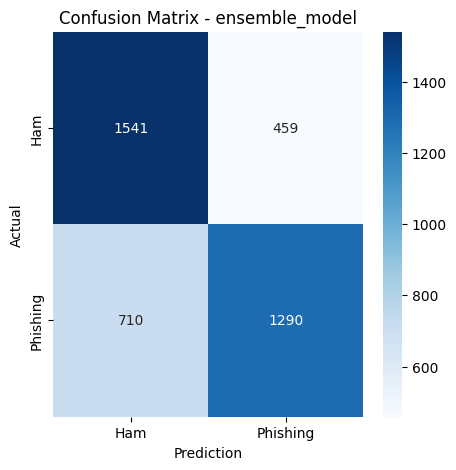

In [24]:
evaluate_model("ensemble_model", test_preprocessed, models_folder)